In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [14]:
#Importando os dados
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv', index_col=0)
sample = pd.read_csv('../sample_submission.csv')

# 5 primeiras linhas do conjunto de treinamento
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


### Análise dos Dados

In [15]:
# Verifica quais colunas não variam (std = 0)
features_to_drop = train.nunique()
features_to_drop = features_to_drop.loc[features_to_drop.values==1].index

# Retira essas colunas dos dados de treino e teste
train = train.drop(features_to_drop,axis=1)
test  = test.drop(features_to_drop,axis=1)

In [16]:
# Como cada atributo se correlaciona com o TARGET
corr_matrix = train.corr()
corr_matrix["TARGET"].sort_values(ascending=False)

TARGET                 1.000000
var36                  0.102919
var15                  0.101322
ind_var8_0             0.046665
num_var8_0             0.046622
                         ...   
ind_var5              -0.135349
num_var42             -0.135693
num_var30             -0.138289
num_meses_var5_ult3   -0.148253
ind_var30             -0.149811
Name: TARGET, Length: 337, dtype: float64

In [17]:
# Verifica se existe algum valor nulo
train.isnull().values.any()

False

In [18]:
y = train['TARGET']
X = train.drop(['ID','TARGET'], axis=1)

# id_test = test['ID']
# X_test = test.drop(['ID'], axis=1)

X.shape, y.shape

((76020, 335), (76020,))

In [19]:
# Verifica a distribuição dos valores
train['TARGET'].value_counts().to_frame()

,TARGET
0,73012
1,3008


In [20]:
# Para escolher entre over sampling e under sampling
# Comenta um e descomenta o outro
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# from imblearn.under_sampling import RandomUnderSampler

# under = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = under.fit_resample(X,y)

y_resampled.value_counts().to_frame().T

,0,1
TARGET,73012,73012


In [21]:
# Divide os dados de treino em treino e validação
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, 
                                                  test_size=0.3, 
                                                  random_state=42, 
                                                  shuffle=True)

X_train.shape, X_val.shape

((102216, 335), (43808, 335))

In [22]:
# Normalização dos dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test = scaler.transform(test)

In [23]:
X_train.shape

(102216, 335)

In [24]:
from tensorflow.keras import models, layers, optimizers, metrics, utils

# Define as variáveis que serão utilizadas posteriormente
batch_size = 1000
epochs = 130
learning_rate = 0.001
hidden_nodes1 = 20
hidden_nodes2 = 20
output_nodes = 1

# Cria o modelo no keras
model = models.Sequential()

model.add(layers.Dense(units=hidden_nodes1, activation='relu', input_shape=(X_train.shape[-1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=hidden_nodes2, activation='relu'))
model.add(layers.Dense(units=output_nodes, activation='sigmoid'))

# Compila o modelo
model.compile(optimizer=optimizers.Adam(learning_rate = learning_rate),loss='binary_crossentropy', metrics=metrics.AUC())

In [25]:
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                6720      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 7,161
Trainable params: 7,161
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Treina o modelo
history = model.fit(X_train, y_train,
            validation_data=(X_val,y_val),
            batch_size=batch_size,
            epochs=epochs)

Epoch 1/130
103/103 [==============================] - 1s 6ms/step - loss: 0.6060 - auc: 0.7739 - val_loss: 0.5276 - val_auc: 0.8013
Epoch 2/130
103/103 [==============================] - 0s 3ms/step - loss: 0.5135 - auc: 0.8151 - val_loss: 0.4742 - val_auc: 0.8673
Epoch 3/130
103/103 [==============================] - 0s 3ms/step - loss: 0.4748 - auc: 0.8564 - val_loss: 0.4467 - val_auc: 0.8793
Epoch 4/130
103/103 [==============================] - 0s 3ms/step - loss: 0.4513 - auc: 0.8731 - val_loss: 0.4243 - val_auc: 0.8919
Epoch 5/130
103/103 [==============================] - 0s 3ms/step - loss: 0.4324 - auc: 0.8838 - val_loss: 0.4084 - val_auc: 0.8988
Epoch 6/130
103/103 [==============================] - 0s 3ms/step - loss: 0.4174 - auc: 0.8918 - val_loss: 0.3947 - val_auc: 0.9053
Epoch 7/130
103/103 [==============================] - 0s 3ms/step - loss: 0.4052 - auc: 0.8977 - val_loss: 0.3827 - val_auc: 0.9095
Epoch 8/130
103/103 [==============================] - 0s 3ms/step - 

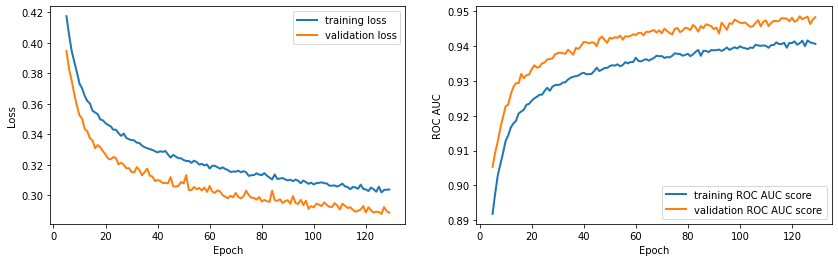

In [27]:
# Mostra os valores dos erros e a curva ROC dsobre o treino e validação
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"auc"], lw=2, label='training ROC AUC score')
plt.plot(logs.loc[5:,"val_auc"], lw=2, label='validation ROC AUC score')
plt.xlabel("Epoch")
plt.ylabel("ROC AUC")
plt.legend(loc='lower right')
plt.show()

In [30]:
sample["TARGET"] = model.predict(test)
sample

,ID,TARGET
0,2,0.401379
1,5,0.466731
2,6,0.007076
3,7,0.186216
4,9,0.022798
...,...,...
75813,151831,0.422721
75814,151832,0.141679
75815,151833,0.048682
75816,151834,0.313659


In [36]:
sample.to_csv('submission.csv',index=False)